# **Machine Learning Modeling**

**1. Define your binary target**

In [1]:
import pandas as pd

df = pd.read_csv("Customer_churn.csv")
df["ChurnFlag"] = df["Churn Category"].notna().astype(int)


**2. Split off ID / churn-meta columns**

In [2]:
X = df.drop(
    ["Customer ID", "Churn Category", "Churn Reason", "ChurnFlag"],
    axis=1
)
y = df["ChurnFlag"]

**3. Train/test split (stratified)**

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.30,
    random_state=42
)

**4. Preprocessing pipeline**

In [4]:
from sklearn.compose    import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_cols = X_train.select_dtypes(include=["number"]).columns
cat_cols = X_train.select_dtypes(include=["object"]).columns

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])

**5. Handle class imbalance**

In [5]:
# Example: Logistic with class_weight
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pipe_lr = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(
        class_weight="balanced", max_iter=1000, random_state=42
    ))
])

**6. Dimensionality reduction + model PCA → Logistic, tuned for recall:**

In [6]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# 1) Define numeric and categorical cols
num_cols = X_train.select_dtypes(include="number").columns.tolist()
cat_cols = X_train.select_dtypes(include="object").columns.tolist()

# 2) Make separate pipelines with imputation
numeric_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# 3) Combine into one transformer
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols)
])

# 4) Full PCA + Logistic pipeline
pipe_pca = Pipeline([
    ("pre", preprocessor),
    ("pca", PCA()),
    ("clf", LogisticRegression(class_weight="balanced", max_iter=1000))
])

param_grid = {
    "pca__n_components": [5, 10, 15, 20],
    "clf__C":             [0.01, 0.1, 1, 10]
}

grid = GridSearchCV(
    pipe_pca,
    param_grid,
    cv=5,
    scoring="recall",
    n_jobs=-1,
    error_score="raise"   # so you’ll see exact failure if it happens
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)

Best params: {'clf__C': 0.1, 'pca__n_components': 20}


**Evaluation on test set**

In [7]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = grid.predict(X_test)
y_proba = grid.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1552
           1       0.86      0.96      0.91       561

    accuracy                           0.95      2113
   macro avg       0.92      0.95      0.94      2113
weighted avg       0.95      0.95      0.95      2113

ROC AUC: 0.9916593160225664


**7. Interpretable model**

In [11]:
# Logistic on all features
pipe_int = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(
        class_weight="balanced",
        penalty="l1",        # L1 helps feature selection
        solver="liblinear",
        max_iter=1000
    ))
])
pipe_int.fit(X_train, y_train)

# Extract and rank coefficients
import numpy as np

# get feature names
ohe = pipe_int.named_steps["pre"].named_transformers_["cat"]
cat_names = ohe.get_feature_names_out(cat_cols)
feat_names = list(num_cols) + list(cat_names)

coefs = pipe_int.named_steps["clf"].coef_[0]
imp = pd.Series(np.abs(coefs), index=feat_names).sort_values(ascending=False)
print("Top 10 predictors:\n", imp.head(5))

Top 10 predictors:
 Customer Status_Churned    7.753403
Customer Status_Stayed     7.702084
Customer Status_Joined     5.296988
Monthly Charge             0.048380
Phone Service_Yes          0.003049
dtype: float64


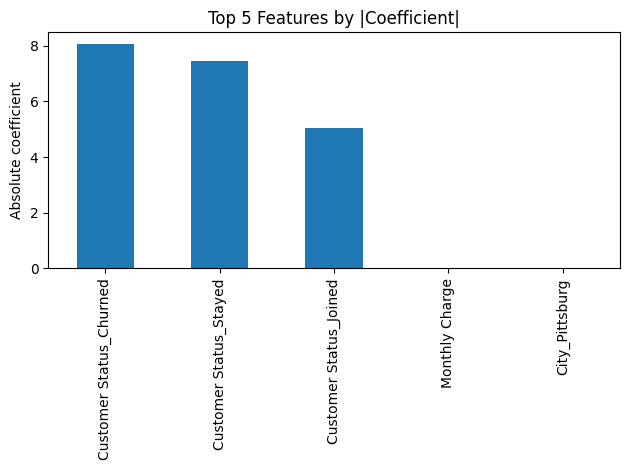

In [10]:
import matplotlib.pyplot as plt

top10 = imp.head(5)
plt.figure()
top10.plot.bar()
plt.title("Top 5 Features by |Coefficient|")
plt.ylabel("Absolute coefficient")
plt.tight_layout()
plt.show()

**ROC & Precision–Recall curves**

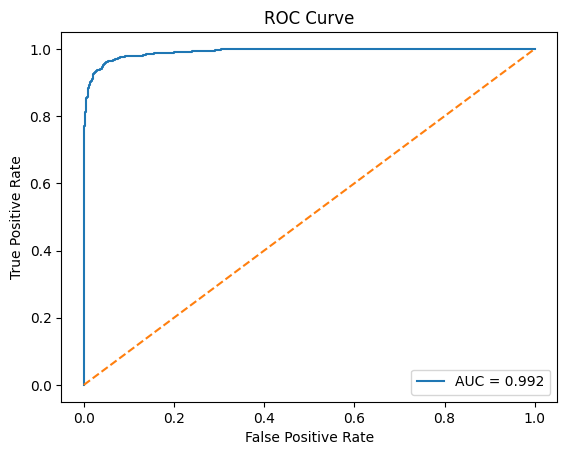

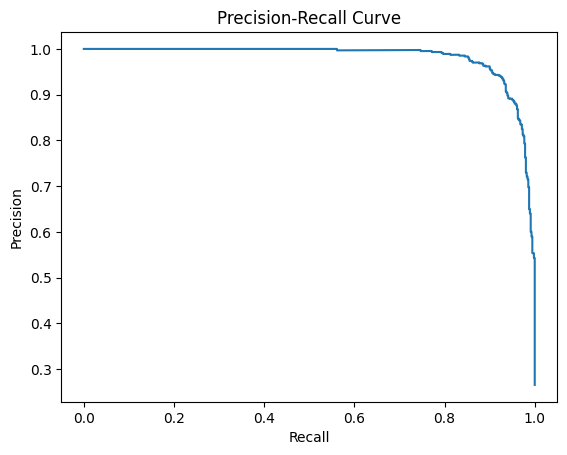

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall
plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


**Measuring train‐set performance**

In [15]:
from sklearn.metrics import classification_report, roc_auc_score

# Predict on train
y_train_pred = grid.predict(X_train)
y_train_proba = grid.predict_proba(X_train)[:, 1]

print("=== TRAIN SET ===")
print(classification_report(y_train, y_train_pred))
print("ROC AUC (train):", roc_auc_score(y_train, y_train_proba))

print("\n=== TEST SET ===")
y_test_pred = grid.predict(X_test)
y_test_proba = grid.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_test_pred))
print("ROC AUC (test):", roc_auc_score(y_test, y_test_proba))

=== TRAIN SET ===
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      3622
           1       0.90      0.96      0.93      1308

    accuracy                           0.96      4930
   macro avg       0.94      0.96      0.95      4930
weighted avg       0.96      0.96      0.96      4930

ROC AUC (train): 0.9944855765902224

=== TEST SET ===
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1552
           1       0.86      0.96      0.91       561

    accuracy                           0.95      2113
   macro avg       0.92      0.95      0.94      2113
weighted avg       0.95      0.95      0.95      2113

ROC AUC (test): 0.9916593160225664


**learning curves**

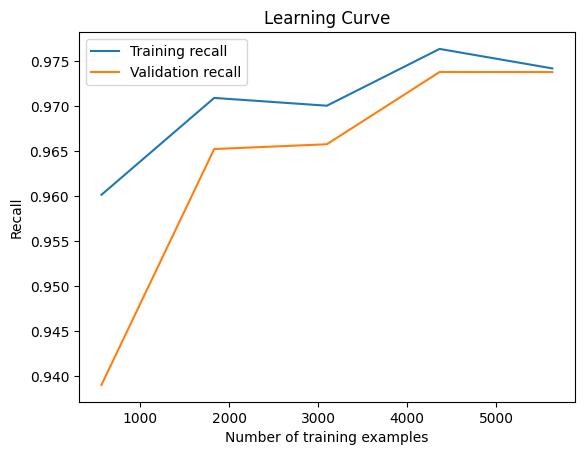

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

est = grid.best_estimator_

train_sizes, train_scores, val_scores = learning_curve(
    est, X, y,
    cv=5,
    scoring="recall",
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
val_mean   = np.mean(val_scores,   axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, label="Training recall")
plt.plot(train_sizes, val_mean,   label="Validation recall")
plt.xlabel("Number of training examples")
plt.ylabel("Recall")
plt.title("Learning Curve")
plt.legend()
plt.show()

**stronger regularization**

In [17]:
param_grid = {
    "pca__n_components": [5, 10],
    "clf__C": [0.001, 0.01, 0.1]       # smaller C = heavier regularization
}
grid_strong = GridSearchCV(pipe_pca, param_grid, cv=5, scoring="recall", n_jobs=-1)
grid_strong.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Number '
                                                                          'of '
                                                                          'Dependents',
                                                                          'Zip '
                                                                          'Code',
                                                                          'Latitude',
                                                                          'Longitude',
                                                                          'Number '
                                                                          'of '
                                                                          'Referrals',
                                                                          'Tenure '
                                                                          'in '
                                                                          'Months',
                                                                          'Avg '
                                                                          'Monthly '
                                                                          'Long '
                                                                          'Distance '
                                                                          'Charges',
                                                                          'Avg '
                                                                          'Monthly '
                                                                          'GB '
                                                                          '...
                                                                          'Plan',
                                                                          'Premium '
                                                                          'Tech '
                                                                          'Support',
                                                                          'Streaming '
                                                                          'TV',
                                                                          'Streaming '
                                                                          'Movies',
                                                                          'Streaming '
                                                                          'Music',
                                                                          'Unlimited '
                                                                          'Data',
                                                                          'Contract',
                                                                          'Paperless '
                                                                          'Billing',
                                                                          'Payment '
                                                                          'Method',
                                                                     

**1. Retraining your final Pipline**






In [18]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# Reuse the preprocessor you built (with imputation + scaling + OHE)
pipe_final = Pipeline([
    ("pre", preprocessor),
    ("pca", PCA(n_components=20)),
    ("clf", LogisticRegression(
        C=0.1,
        class_weight="balanced",
        max_iter=1000,
        random_state=42
    ))
])

# Fit on full train
pipe_final.fit(X_train, y_train)

# Test‐set evaluation
y_test_pred  = pipe_final.predict(X_test)
y_test_proba = pipe_final.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, y_test_pred))
print("ROC AUC:", roc_auc_score(y_test, y_test_proba))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1552
           1       0.86      0.96      0.91       561

    accuracy                           0.95      2113
   macro avg       0.92      0.95      0.94      2113
weighted avg       0.95      0.95      0.95      2113

ROC AUC: 0.9916558704081445


**2. Inspecting explained-variance of your 20 components**

In [19]:
explained = pipe_final.named_steps["pca"].explained_variance_ratio_
print(f"Total variance explained by 20 components: {explained.sum():.3%}")

Total variance explained by 20 components: 85.767%
